In [1]:
# Initialize Otter 
import otter
grader = otter.Notebook("proj01.ipynb")

<table style="width: 100%;" id="nb-header">
    <tr style="background-color: transparent;"><td>
        <img src="https://data-88e.github.io/assets/images/blue_text.png" width="250px" style="margin-left: 0;" />
    </td><td>
        <p style="text-align: right; font-size: 10pt;"><strong>Economic Models</strong>, Fall 2024<br>
            Dr. Eric Van Dusen <br>
        Alan Liang <br>
        Akhil Venkatesh <br>
</table>

# Project 1: Airbnb

In this project, we will empirically examine the fundamental concepts of supply and demand through Airbnb rentals in Boston. We will also analyze the effects of occupancy taxes on the short-term rental market, which were enacted by the Massachusetts state legislature on July 1st, 2019. 

The project is roughly divided into 3 large parts:
- In the first part, you will conduct some data processing and create a demand curve from (imputed) Airbnb transactions. 
- In the second part, you will create a supply curve for Airbnb listings and determine the market equilibrium.
- In the third part, you will examine the effects of the occupancy tax on the market.

Throughout the project, you may find it helpful to refer to the first couple [textbook chapters](https://data-88e.github.io/textbook/content/01-demand/index.html) and the Week 2 & 3 lecture slides.  

In [2]:
from datascience import *
import numpy as np
import matplotlib.pyplot as plt
import sympy
sympy.init_printing(print_builtin=False)
solve = lambda x,y: sympy.solve(x-y)[0] if len(sympy.solve(x-y))==1 else "Not Single Solution"
%matplotlib inline

## The Data

The data for this project originates from [*Inside Airbnb*](http://insideairbnb.com/), an independent investigatory project that collects and hosts substantial Airbnb data on more than 100 cities around the world. The data collected by *Inside Airbnb* is web-scraped from the Airbnb website on a roughly monthly basis. Although *Inside Airbnb* was originally started by its creators to investigate the effects of Airbnb on affordable housing and exacerbating gentrification, the data is made public for free and open for use. 

For this project, we will be examining Airbnb transactions and listings 3 months around July 1st, 2019 (i.e. April to September 2019) due to its proximity to the enactment of the occupancy tax. 

Let's go ahead and load in the dataset `airbnb.csv`.

In [3]:
boston = Table.read_table("airbnb.csv")
boston

month,date,dow,id,price,neighbourhood,room_type,master_key
4,1,0,5506,145,Roxbury,Entire home/apt,1
4,2,1,5506,145,Roxbury,Entire home/apt,1
4,3,2,5506,145,Roxbury,Entire home/apt,1
4,4,3,5506,145,Roxbury,Entire home/apt,1
4,5,4,5506,145,Roxbury,Entire home/apt,1
4,6,5,5506,145,Roxbury,Entire home/apt,1
4,7,6,5506,145,Roxbury,Entire home/apt,1
4,8,0,5506,145,Roxbury,Entire home/apt,1
4,9,1,5506,145,Roxbury,Entire home/apt,1
4,10,2,5506,145,Roxbury,Entire home/apt,2


Each row of `boston` refers to a listing's availability for a particular date. Thus, the *granularity* of the data is on a listing-day level. This is because our 'atomic unit' of transactions (the definition of 1 unit of a good) is on the per listing per night level.

The columns of the table are as follows:
* The `month` and `date` refer to the month and the day of the month of a unit-night (in 2019). 
* The `dow` indicates the day of the week, where 0 is Monday, 1 is Tuesday and so on.
* The `id` column references the id of the Airbnb unit. Each ID uniquely determines a listing, and every listing only has 1 ID. (You can visit each listing's URL on Airbnb by going to https://www.airbnb.com/rooms/YOUR_ID_HERE with the id to look up the listing on the airbnb website.)
* The `price` column shows the price of the listing for the given date.
* The `neighbourhood` and `room_type` columns show the neighborhood (within in Boston) and type of unit the accommodation is offered in. 
* The `master_key` columns contains 2 integer values. 
    - `1` denotes the situation when a property was offered for rent but **not booked** by a guest.
    - `2` denotes the situation when a property was offered for rent and **booked** by a guest.

Let's go over an example by taking a look at listing 5506 in the month of April:

In [4]:
boston.where("id", 5506).where('month', 4)

month,date,dow,id,price,neighbourhood,room_type,master_key
4,1,0,5506,145,Roxbury,Entire home/apt,1
4,2,1,5506,145,Roxbury,Entire home/apt,1
4,3,2,5506,145,Roxbury,Entire home/apt,1
4,4,3,5506,145,Roxbury,Entire home/apt,1
4,5,4,5506,145,Roxbury,Entire home/apt,1
4,6,5,5506,145,Roxbury,Entire home/apt,1
4,7,6,5506,145,Roxbury,Entire home/apt,1
4,8,0,5506,145,Roxbury,Entire home/apt,1
4,9,1,5506,145,Roxbury,Entire home/apt,1
4,10,2,5506,145,Roxbury,Entire home/apt,2


Looking at the first row, we see that it refers to listing 5506, which you can check out on Airbnb [here](https://www.airbnb.com/rooms/5506). This row corresponds to April 1st, 2019, which was a Monday. The price that night was \$145. The unit is located in the Roxbury neighborhood and is an entire home or apartment. Lastly, the unit was not occupied by a guest on April 1st, 2019. 

Lastly, before we get started, it is also a good idea to keep in mind the idea of *implicit costs*: hosts can decide to block out a set of dates on their calendar and not rent out the listing at all on those dates. As economists we will assume that intentionally not renting out a unit is associated with an opportunity cost and can thus be considered as some sort of *implicit demand*.

For example, the listing with ID `442735` did not offer the unit for quite a few nights in the month of April. 
This reflects the opportunity cost of hosts for not renting for a night, and consuming the product themselves. 

In [5]:
boston.where("id", 442735).where('month', 4)

month,date,dow,id,price,neighbourhood,room_type,master_key
4,12,4,442735,800,South End,Entire home/apt,2
4,13,5,442735,800,South End,Entire home/apt,2
4,14,6,442735,800,South End,Entire home/apt,2
4,15,0,442735,800,South End,Entire home/apt,2
4,16,1,442735,800,South End,Entire home/apt,2
4,17,2,442735,350,South End,Entire home/apt,2
4,18,3,442735,350,South End,Entire home/apt,2
4,19,4,442735,350,South End,Entire home/apt,2
4,20,5,442735,350,South End,Entire home/apt,2


## Preprocessing the Data

In the perfect world, supply and demand curves denote the quantity demanded and supplied at different prices for *homogeneous goods*, i.e. goods that are basically the same all factors considered. The examples we've covered so far, such as electricity or beef, fit this definition well, but Airbnb units (and their associated dates) are typically quite diverse. This casts a little bit of uncertainty in generalizing our results, but we'll try our best to control for certain factors.

Let's start with an obvious difference: some Airbnb listings are private rooms, some are entire homes/apartments, and some are shared rooms. Conceivably, the type of Airbnb a listing will attract a different set of guests and be offered at different price points. 

**Question 1.1**: Let's restrict our analysis to only listings that entire homes or apartments; it turns out that a majority of the properties are of either entire homes or entire apartments. Save your results to `boston_q1_1` table, using the previous `boston` table.


In [6]:
boston_q1_1 = boston.where("room_type", "Entire home/apt")
boston_q1_1

month,date,dow,id,price,neighbourhood,room_type,master_key
4,1,0,5506,145,Roxbury,Entire home/apt,1
4,2,1,5506,145,Roxbury,Entire home/apt,1
4,3,2,5506,145,Roxbury,Entire home/apt,1
4,4,3,5506,145,Roxbury,Entire home/apt,1
4,5,4,5506,145,Roxbury,Entire home/apt,1
4,6,5,5506,145,Roxbury,Entire home/apt,1
4,7,6,5506,145,Roxbury,Entire home/apt,1
4,8,0,5506,145,Roxbury,Entire home/apt,1
4,9,1,5506,145,Roxbury,Entire home/apt,1
4,10,2,5506,145,Roxbury,Entire home/apt,2


In [7]:
grader.check("q1_1")

q1_1 results: All test cases passed!

**Question 1.2**: In addition, it is conceivable that prices and the types of consumers are substantially different between weekdays and weekends, implying ultimately different types of goods. Let's restrict our analysis further to account for the day of the week by focusing on Friday and Saturday. Save your results to the same `boston_q1_2` table, using the previous `boston_q1_1` table.

_Hint:_ How are weekday values encoded in the `dow` column?


In [8]:
boston_q1_2 = boston_q1_1.where('dow', are.between_or_equal_to(4, 5))
boston_q1_2

month,date,dow,id,price,neighbourhood,room_type,master_key
4,5,4,5506,145,Roxbury,Entire home/apt,1
4,6,5,5506,145,Roxbury,Entire home/apt,1
4,12,4,5506,250,Roxbury,Entire home/apt,2
4,13,5,5506,250,Roxbury,Entire home/apt,2
4,19,4,5506,145,Roxbury,Entire home/apt,2
4,20,5,5506,145,Roxbury,Entire home/apt,2
4,26,4,5506,145,Roxbury,Entire home/apt,1
4,27,5,5506,145,Roxbury,Entire home/apt,1
5,3,4,5506,145,Roxbury,Entire home/apt,2
5,4,5,5506,145,Roxbury,Entire home/apt,2


In [9]:
grader.check("q1_2")

q1_2 results: All test cases passed!

**Question 1.3**: To remove outliers, let's also remove listing nights in which the per-night price was \$1000 or greater. Save your results to the `boston_q1_3` table, using the previous `boston_q1_2` table.


In [10]:
boston_q1_3 = boston_q1_2.where("price", are.below(1000))
boston_q1_3

month,date,dow,id,price,neighbourhood,room_type,master_key
4,5,4,5506,145,Roxbury,Entire home/apt,1
4,6,5,5506,145,Roxbury,Entire home/apt,1
4,12,4,5506,250,Roxbury,Entire home/apt,2
4,13,5,5506,250,Roxbury,Entire home/apt,2
4,19,4,5506,145,Roxbury,Entire home/apt,2
4,20,5,5506,145,Roxbury,Entire home/apt,2
4,26,4,5506,145,Roxbury,Entire home/apt,1
4,27,5,5506,145,Roxbury,Entire home/apt,1
5,3,4,5506,145,Roxbury,Entire home/apt,2
5,4,5,5506,145,Roxbury,Entire home/apt,2


In [11]:
grader.check("q1_3")

q1_3 results: All test cases passed!

<!-- BEGIN QUESTION -->

**Question 1.4**: What other factors may differ across Airbnb listings? This is an open ended question, so points will be awarded on answers that indicate effort and are reasonably justified. Note that these factors *do not* have to exist in the given columns.


_Room size will also be a factor. This is because demand and tax are different depending on room size. In Airbnb demand and supply, room size is heavily influenced by taxes. Big rooms are more taxed, which can lead to higher prices, which can reduce the demand for travelers. Also, high taxes can cause hosts to reduce the supply of big rooms or raise prices due to the maintenance cost burden. Conversely, in areas with low taxes, the supply of big rooms can increase. Consequently, room size is closely linked to taxes, affecting supply and demand._

<!-- END QUESTION -->

**Question 1.5**: We will split our analysis in two periods: before and after the tax. Create a table called `boston_pre`, using the `boston_q1_3` table, that contains all listing-nights observations before the occupancy tax, which came into effect on July 1st, 2019.


In [12]:
boston_pre = boston_q1_3.where("month", are.between_or_equal_to(4, 6))
boston_pre

month,date,dow,id,price,neighbourhood,room_type,master_key
4,5,4,5506,145,Roxbury,Entire home/apt,1
4,6,5,5506,145,Roxbury,Entire home/apt,1
4,12,4,5506,250,Roxbury,Entire home/apt,2
4,13,5,5506,250,Roxbury,Entire home/apt,2
4,19,4,5506,145,Roxbury,Entire home/apt,2
4,20,5,5506,145,Roxbury,Entire home/apt,2
4,26,4,5506,145,Roxbury,Entire home/apt,1
4,27,5,5506,145,Roxbury,Entire home/apt,1
5,3,4,5506,145,Roxbury,Entire home/apt,2
5,4,5,5506,145,Roxbury,Entire home/apt,2


In [13]:
grader.check("q1_5")

q1_5 results: All test cases passed!

## Building the Demand Curve

Now that we have controlled for some factors that might cause heterogeneity in our observations, we can go ahead and create the demand curve.

**Question 2.1**: Filter `boston_pre` for only those rentals that were actually transacted, i.e, where `master_key` is `2`. Assign this table to the name `boston_pre_demand`.


In [14]:
boston_pre_demand = boston_pre.where("master_key", 2)
boston_pre_demand

month,date,dow,id,price,neighbourhood,room_type,master_key
4,12,4,5506,250,Roxbury,Entire home/apt,2
4,13,5,5506,250,Roxbury,Entire home/apt,2
4,19,4,5506,145,Roxbury,Entire home/apt,2
4,20,5,5506,145,Roxbury,Entire home/apt,2
5,3,4,5506,145,Roxbury,Entire home/apt,2
5,4,5,5506,145,Roxbury,Entire home/apt,2
5,10,4,5506,145,Roxbury,Entire home/apt,2
5,11,5,5506,145,Roxbury,Entire home/apt,2
5,24,4,5506,145,Roxbury,Entire home/apt,2
5,25,5,5506,145,Roxbury,Entire home/apt,2


In [15]:
grader.check("q2_1")

q2_1 results: All test cases passed!

The supply and demand curve show the number of consumers who are willing to purchase a good and the number of goods the producer is willing to produce at any price. However, prices are often noisy and each producer is able to set their own price, making it difficult to account for demand properly at each individual price.

One solution is to group the prices into bins by using the [`tbl.bin(...)`](http://data8.org/datascience/_autosummary/datascience.tables.Table.bin.html) method. We know that this function is new and will not be covered in Data 8, so here is an example of what `tbl.bin` does.

In [16]:
# Create an example table
example_tbl = Table().with_columns(
    "fruits", make_array("apples", "pears", "bananas", "cherries", "dragonfruit", "mangoes", "strawberries"),
    "price", make_array(1, 2, 1, 3, 5, 6, 12)
)
example_tbl

fruits,price
apples,1
pears,2
bananas,1
cherries,3
dragonfruit,5
mangoes,6
strawberries,12


In [17]:
bins = np.arange(0, 20, 5) # make an array with values [0, 5, 10, 15]
example_tbl.bin("price", bins = bins)

bin,price count
0,4
5,2
10,1
15,0


What did `tbl.bin` do? First, we created an array of 4 values from 0 to 15 that each correspond to the left end of a bin. In the first bin, there are 4 entries of `fruits` with prices that are between 0 and 5 (not inclusive of 5). In the second bin, there are 2 entries with prices between 5 and 10 (not inclusive of 10), and so on. The binned table will display the number of counts (number of occurrences) within each bin.

**Question 2.2**:  Now that you have an understanding of how to group values of a table into bins, let's use `tbl.bin` to group the prices into 50 equally spaced bins from \\$0 to \\$1000. Store this in a new table called `boston_pre_demand_binned`, with the column `price` representing the left end for each price bin and the column `quantity` representing the amount of nights transacted at that corresponding price bin.

*Hint*: Using `np.arange`, how large should each step size be?


In [18]:
bins = np.arange(0, 1020, 20)
boston_pre_demand_binned = boston_pre_demand.bin("price", bins=bins)
boston_pre_demand_binned = boston_pre_demand_binned.relabeled("bin", "price")
boston_pre_demand_binned = boston_pre_demand_binned.relabeled("price count", "quantity")

boston_pre_demand_binned

price,quantity
0,0
20,0
40,0
60,4
80,50
100,68
120,277
140,502
160,457
180,318


In [19]:
grader.check("q2_2")

q2_2 results: All test cases passed!

Let's create a scatter plot of price and quantity to visualize the relationship.

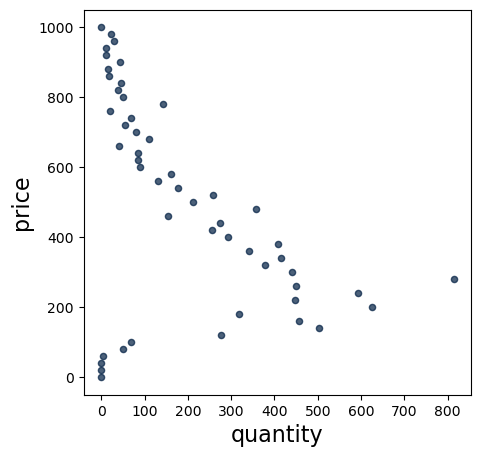

In [20]:
boston_pre_demand_binned.scatter("quantity", "price")
plt.xlabel('quantity')
plt.ylabel('price');

Is this the demand curve? 

Although the plot may look like it exhibits a downward sloping relationship between price and quantity, this is not the actual demand curve. What this scatter plot shows is the price at which rentals were booked and the quantity of bookings at those *specific* prices. **It does not show the total amount of bookings that would be demanded at those prices.**

For example, at the price of \\$60, everyone who has paid a higher amount would still demand and gladly book a rental at that lower price. So the quantity demanded at \\$60 is all the people who paid \\$60 or more. Similarly, the quantity demanded at \\$80 should be all the people who paid \$80 or more. 

Consider the following toy example. Suppose we observe the following transactions:
    
| Price Transacted | Quantity Transacted |
|------------------|---------------------|
| 1                | 2                   |
| 2                | 3                   |
| 3                | 1                   |
| 4                | 0                   |

The quantity demanded would be as follows:

| Price Transacted | Quantity Demanded   |
|------------------|---------------------|
| 1                | 6                   |
| 2                | 4                   |
| 3                | 1                   |
| 4                | 0                   |


Note that we've assumed all units are the same and equally interchangeable. We attempted in part 1 to restrict our analysis to units that were more similar, but this approach is far from perfect.

**Question 2.3:** Create a new column called `quantity_demanded` to show the quantity demanded at a given price and add it to the table `boston_pre_demand_binned`.

_Hint:_ You may need to use the function [`np.flip`](https://numpy.org/doc/stable/reference/generated/numpy.flip.html)  (which reverses the array) and [`np.cumsum`](https://numpy.org/doc/stable/reference/generated/numpy.cumsum.html) to construct the `quantity_demanded` array. Make sure to double check that your code would work on the toy example above!


In [21]:
quantity_demanded = np.flip(np.cumsum(np.flip(boston_pre_demand_binned.column('quantity'))))
boston_pre_demand_binned = boston_pre_demand_binned.with_column('quantity_demanded', quantity_demanded)
boston_pre_demand_binned

price,quantity,quantity_demanded
0,0,9912
20,0,9912
40,0,9912
60,4,9912
80,50,9908
100,68,9858
120,277,9790
140,502,9513
160,457,9011
180,318,8554


In [22]:
grader.check("q2_3")

q2_3 results: All test cases passed!

Let's plot the demand curve. 

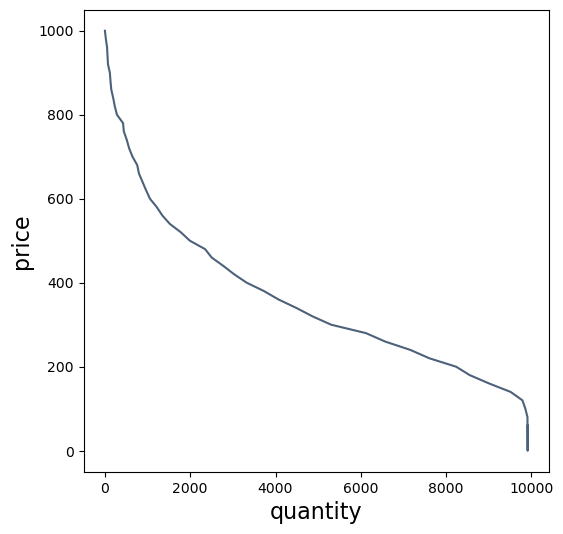

In [23]:
boston_pre_demand_binned.plot("quantity_demanded", "price")
plt.xlabel('quantity')
plt.ylabel('price');

Now it's time to find a linear equation for the demand curve.

**Question 2.4.1**: Determine the demand curve, expressed as quantity in terms of price, using `np.polyfit`. Assign the values `demand_slope` and `demand_intercept` to their respective values.


In [24]:
demand_params = np.polyfit(boston_pre_demand_binned.column("price"), boston_pre_demand_binned.column("quantity_demanded"), 1)
demand_slope = demand_params[0]
demand_intercept = demand_params[1]

print("The demand slope is:", demand_slope)
print("The demand intercept is:", demand_intercept)

The demand slope is: -11.6904253394
The demand intercept is: 9465.91855204


In [25]:
grader.check("q2_4_1")

q2_4_1 results: All test cases passed!

**Question 2.4.2**: Interpret the slope and intercept terms of the demand curve. It may be also helpful to represent quantity as a function of price as well. Assume you have correct `demand_slope` and `demand_intercept` from the previous question. Let `abs(demand_slope)` be the absolute value of `demand_slope`.

a. The slope tells us that a 1 dollar decrease in price per night is associated with around `abs(demand_slope)` less nights transacted. The intercept states that at `demand_intercept` dollars a night, the total number of nights demanded is 0.
<br>
b. The slope tells us that a 1 dollar decrease in price per night is associated with around `abs(demand_slope)` more nights transacted. The intercept states that at `demand_intercept` dollars a night, the total number of nights demanded is 0.
<br>
c. The slope tells us that a 1 dollar increase in price per night is associated with around `abs(demand_slope)` less nights transacted. The intercept states that at 0 dollars a night, the total number of nights demanded is `demand_intercept`.
<br>
d. The slope tells us that a 1 dollar increase in price per night is associated with around `abs(demand_slope)` more nights transacted. The intercept states that at 0 dollars a night, the total number of nights demanded is `demand_intercept`.
<br>

Assign the letter corresponding to your answer to `q2_4_2` below.

In [26]:
q2_4_2 = "c"

In [27]:
grader.check("q2_4_2")

q2_4_2 results: All test cases passed!

**Question 2.5**: Now let's construct a formula for the demand curve. We will express the demand curve as quantity expressed in terms of price. Using SymPy, create a symbol `P` and assign `demand` to the demand curve using the slope and intercept values from above.


In [28]:
from sympy import Symbol

P = Symbol('P')
demand = demand_slope * P + demand_intercept
demand

In [29]:
grader.check("q2_5")

q2_5 results: All test cases passed!

**Question 2.6**: Using the log-log formula, determine the price elasticity for demand and assign it to the variable `demand_elasticity`. You may assume that the price elasticity is constant. Make sure to use the table `boston_demand_log`, which takes out the first and last rows of the previous table.


In [30]:
# This will take out the first and last row of the table, which are 0's and cannot be log transformed properly
boston_demand_log = boston_pre_demand_binned.take(np.arange(1, boston_pre_demand_binned.num_rows - 1))

log_price = np.log(boston_demand_log.column("price"))
log_quantity = np.log(boston_demand_log.column("quantity_demanded"))

demand_elasticity = np.polyfit(log_price, log_quantity, 1)[0]
demand_elasticity

-1.5244261403604127

In [31]:
grader.check("q2_6")

q2_6 results: All test cases passed!

**Question 2.7**: Is the price elasticity of demand for Airbnb's elastic or inelastic?

<ol type="A" style="list-style-type: lower-alpha;">
    <li>elastic</li>
    <li>inelastic</li>
</ol>

Assign the letter corresponding to your answer to `q2_7` below.


In [32]:
q2_7 = "b"

In [33]:
grader.check("q2_7")

q2_7 results: All test cases passed!

## Constructing the Supply Curve

With our demand curve constructed, we can now move onto the supply curve. You'll find that this procedure is going to similar to the one you've just completed above. 

**Question 3.1**: Before constructing the supply curve, let's do an exercise to further understand the relationship between demand and supply. Using `boston_pre_demand` and `boston_pre` tables, let's find the total number of properties demanded vs supplied. Save your results to `total_demand` and `total_supply`. 

*Hint: What is the difference between `boston_pre` and `boston_pre_demand`?*


In [34]:
total_demand = boston_pre_demand.num_rows
total_supply = boston_pre.num_rows

In [35]:
grader.check("q3_1")

q3_1 results: All test cases passed!

**Question 3.2**: With the same bins as demand above, use `tbl.bin` to group the prices in entire `boston_pre` into 50 equally spaced bins from \$0 to \$1000. Store this in a new table called `boston_pre_supply_binned`, with the column `price` representing the left end for each price bin and the column `quantity` representing the amount of nights supplied at that corresponding price bin.

**You should use the same bins as in Question 2.2.**


In [36]:
bins = np.arange(0, 1020, 20)
boston_pre_supply_binned = boston_pre.bin("price", bins=bins)
boston_pre_supply_binned = boston_pre_supply_binned.relabeled("bin", "price")
boston_pre_supply_binned = boston_pre_supply_binned.relabeled("price count", "quantity")
boston_pre_supply_binned

price,quantity
0,0
20,0
40,0
60,25
80,195
100,232
120,485
140,835
160,775
180,662


In [37]:
grader.check("q3_2")

q3_2 results: All test cases passed!

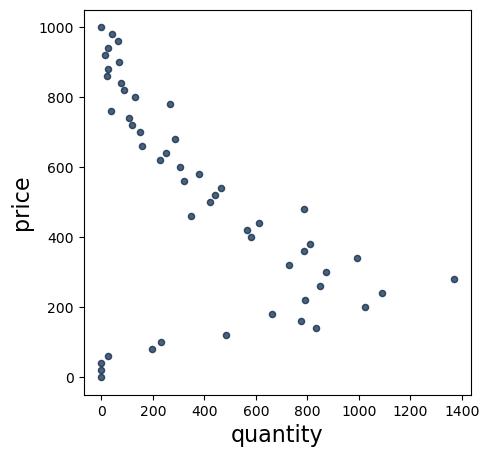

In [38]:
boston_pre_supply_binned.scatter("quantity", "price")
plt.xlabel('quantity')
plt.ylabel('price');

This isn't the supply curve, yet. The scatter plot shows the price at which rentals were offered and the quantity of offerings *specifically* at those prices. 

The total supply at any given price includes all the suppliers willing to offer at the price. 
For example, the supplier offering at \$60 would gladly take \$80. 
Thus, that host should be included in the quantity supplied at \$80.


**Question 3.3**: Create a new column called `quantity_supplied` to show the actual quantity supplied at a given price and add it to the table `boston_pre_supply_binned`.

_Hint:_ You will need to use `np.cumsum` here as in Question 2.3, but do you need `np.flip`?


In [39]:
quantity_supplied = np.cumsum(np.flip(boston_pre_supply_binned.column('quantity')))
boston_pre_supply_binned = boston_pre_supply_binned.with_column('quantity_supplied', quantity_supplied)
boston_pre_supply_binned

price,quantity,quantity_supplied
0,0,0
20,0,42
40,0,107
60,25,133
80,195,148
100,232,216
120,485,243
140,835,266
160,775,344
180,662,433


In [40]:
grader.check("q3_3")

q3_3 results: All test cases passed!

<!-- BEGIN QUESTION -->

**Question 3.4**: Plot the supply curve using a line plot.


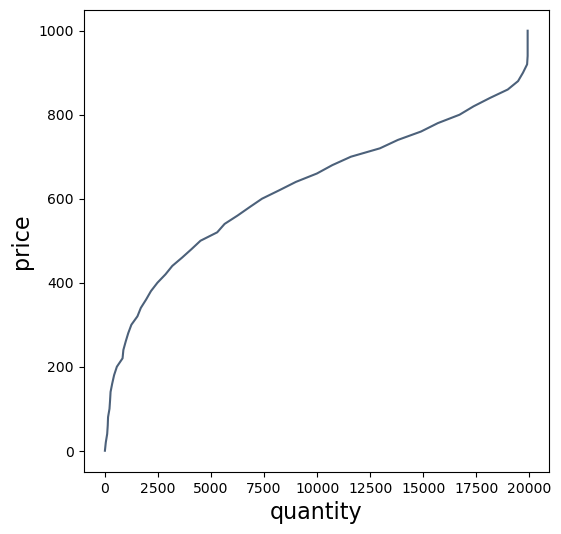

In [41]:
boston_pre_supply_binned.plot("quantity_supplied", "price")
plt.xlabel('quantity')
plt.ylabel('price');

<!-- END QUESTION -->

**Question 3.5**: Using `np.polyfit` assign the values `supply_slope` and `supply_intercept` to their respective values.


In [42]:
supply_params = np.polyfit(boston_pre_supply_binned.column("quantity_supplied"), boston_pre_supply_binned.column("price"), 1)
supply_slope = supply_params[0]
supply_intercept = supply_params[1]

print("The supply slope is:", supply_slope)
print("The supply intercept is:", supply_intercept)

The supply slope is: 0.0382272050159
The supply intercept is: 212.407742029


In [43]:
grader.check("q3_5")

q3_5 results: All test cases passed!

**Question 3.6**: Using SymPy, construct a formula for the supply curve and store it to `supply`. Make sure to use the same symbol `P` as in Question 2.5!


In [44]:
supply = supply_slope * P + supply_intercept
supply

/tmp/ipykernel_123/2373002744.py:1: RuntimeWarning: invalid value encountered in multiply
  supply = supply_slope * P + supply_intercept


In [45]:
grader.check("q3_6")

q3_6 results: All test cases passed!

**Question 3.7**: Using the log-log formula, determine the price elasticity for supply and assign it to the variable `supply_elasticity`. You may assume that the price elasticity is constant. Make sure to use the table `boston_supply_log`. 


In [46]:
# This will take out the rows that feature 0's and cannot be log transformed properly
boston_supply_log = boston_pre_supply_binned.take(np.arange(3, boston_pre_demand_binned.num_rows))

log_price = np.log(boston_supply_log.column("price"))
log_quantity = np.log(boston_supply_log.column("quantity_supplied"))

supply_elasticity = np.polyfit(log_price, log_quantity, 1)[0]
supply_elasticity

2.1299341389523812

In [47]:
grader.check("q3_7")

q3_7 results: All test cases passed!

<!-- BEGIN QUESTION -->

**Question 3.8**: Is supply elastic or inelastic? How does it compare to the price elasticity of demand?


_The supply is elastic. The price elasticity of demand is negative and elasticity of supply is positive._

<!-- END QUESTION -->

## Solving for Equilibria

Now that we have both the demand and supply curves, we are able to determine the equilibrium. The equilibrium point denotes the total amount of units that would be transacted in the market and its associated price level. 

**Question 4.1**: Use the `solve` function provided to find the price equilibrium value and assign it to `P_star`. We also recommend that you write out and solve the algebra by hand to double check your work. 


In [48]:
P_star = solve(demand, supply)
P_star

In [49]:
grader.check("q4_1")

q4_1 results: All test cases passed!

**Question 4.2**: Determine the quantity equilibrium value and assign it to `Q_star`. 


In [50]:
Q_star = demand.subs(P, P_star)
Q_star

In [51]:
grader.check("q4_2")

q4_2 results: All test cases passed!

Let's look that both the curves in the same plot.

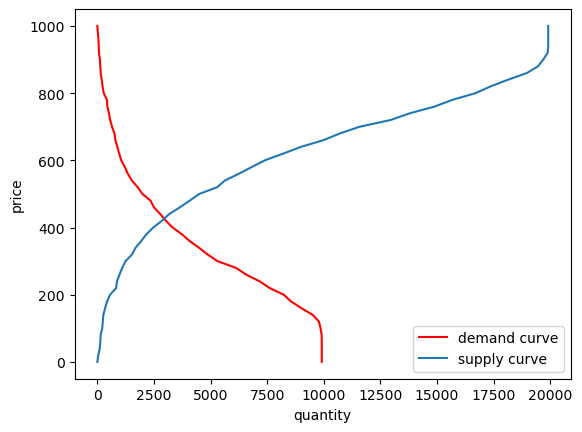

In [52]:
plt.figure(dpi=100)
plt.plot(
    boston_pre_demand_binned.column("quantity_demanded"), 
    boston_pre_demand_binned.column("price"), color = 'red', 
    label = 'demand curve')
plt.plot(
    boston_pre_supply_binned.column("quantity_supplied"), 
    boston_pre_supply_binned.column("price"), 
    label = 'supply curve')
plt.xlabel('quantity')
plt.ylabel('price')
plt.legend();

Why do these curves look different than the normal linear supply and demand curves in the textbook? It's because in the textbook we've made a vastly simplifying assumptions that supply and demand curves are linear in nature. This would imply that, no matter at what price, a price decrease by \\$1 would change the amount supplied or demanded by the same amount. 

Is this intuitively true? Probably not. For example, a \\$1 decrease from \\$100 is trivial compared to a \\$1 decrease from an original price of \\$2. As humans, we think about changes as proportions, and this fact should be reflected in the supply and demand curves. What this implies is that these curves should be exponential in nature: at higher prices, a larger change in price will yield the same change quantity as compared to that in lower prices. 

Your curves above should look somewhat exponential, which aligns with this intuition!

Another caveat: our results show a kind of 'local' effect and may not necessarily be generalizable to all Airbnb units everywhere. Recall that from our filters in part 1, our market only describes goods that are Airbnb stays in entire homes/apartments that occurred on the weekend over during the early summer months of 2019 (pre-July). 

## Introducing a Tax

As a popular alternative to hotels, Airbnb has become subject to occupancy taxes in cities around the world. These taxes are applied to short term lodgings and are typically enforced by local or state governments in the United States. Proponents of the tax argue that existing rules that apply to hotels should also be enforced for Airbnb. Opponents instead argue that these laws do not apply to services created out of excess capacity, and the tax would stifle innovation and growth in the industry<sup>2</sup>.

In the week following Christmas in 2018, Massachusetts governor Charlie Baker signed into law *An Act Regulating and Insuring Short-Term Rentals*, which imposed a 14.95% excise tax to short term rental bookings in Boston, beginning on July 1st 2019.

The image below of an Airbnb in Boston shows guests a cost breakdown of their stay right before booking a listing, including the different taxes that comprise the "occupancy taxes and fees" section. You do not need to worry about what these different types of taxes mean; the main takeaway here is that the total tax of \$44 is roughly 14.95% of the cost (including service and cleaning fees), and is paid by the guest on booking. 

<img src="airbnb_booking.png" alt="drawing" width="600"/>


**Question 5.1**: Which party bears the statutory incidence of the tax?

<ol style="list-style-type: lower-alpha;">
    <li>the hosts (producers)</li>
    <li>the guests (consumers)</li>
    <li>Airbnb (platform)</li>
</ol>

Assign `statutory_incidence` to the letter corresponding to your answer.


In [53]:
statutory_incidence = "b"

In [54]:
grader.check("q5_1")

q5_1 results: All test cases passed!

**Question 5.2**: Based on the price elasticities of supply and demand we have calculated above, would we expect the economic incidence of the tax to be:

<ol style="list-style-type: lower-alpha;">
    <li>Largely bore by producers</li>
    <li>Largely bore by consumers</li>
    <li>Roughly equally bore by producers and consumers</li>
</ol>

Assign `economic_incidence` to the letter corresponding to your answer.

*Hint*: Refer back to the elasticities you calculated earlier in Questions 2.6 and 3.8


In [55]:
economic_incidence = "c"

In [56]:
grader.check("q5_2")

q5_2 results: All test cases passed!

Now we will calculate the demand curve post-tax. You may notice that this procedure yields a similar table as the one in section 2.

In [57]:
boston_post = boston.where("month", are.above(6))
# apply the same filters that we did in q1.1, q1.2
boston_post_filtered = boston_post.where("room_type", are.equal_to("Entire home/apt")).where("dow", are.between_or_equal_to(4, 5))
boston_post_demand = boston_post_filtered.where('master_key', are.equal_to(2))
boston_post_demand_binned = boston_post_demand.bin("price", bins=bins)
boston_post_demand_binned = boston_post_demand_binned.relabeled('bin', 'price')
boston_post_demand_binned = boston_post_demand_binned.relabeled('price count', 'quantity')
quantity_demanded = np.flip(np.cumsum(np.flip(boston_post_demand_binned.column("quantity"))))
boston_post_demand_binned = boston_post_demand_binned.with_column("quantity_demanded", quantity_demanded)
boston_post_demand_binned

price,quantity,quantity_demanded
0,0,6071
20,0,6071
40,0,6071
60,4,6071
80,8,6067
100,48,6059
120,212,6011
140,296,5799
160,282,5503
180,245,5221


Let's plot both demand curves, pre and post tax, with the pre-tax supply curve. For this project, to simplify our assumptions we'll assume that the supply curve does not change due to the tax. 

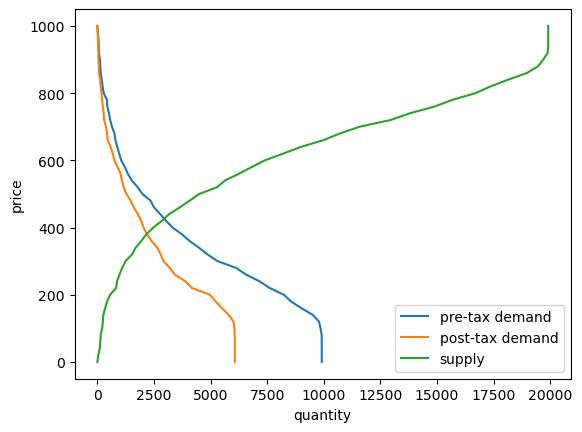

In [58]:
plt.figure(dpi=100)
plt.plot(
    boston_pre_demand_binned.column("quantity_demanded"), 
    boston_pre_demand_binned.column("price"), 
    label = "pre-tax demand")
plt.plot(
    boston_post_demand_binned.column("quantity_demanded"), 
    boston_post_demand_binned.column("price"), 
    label = "post-tax demand")
plt.plot(
    boston_pre_supply_binned.column("quantity_supplied"), 
    boston_post_demand_binned.column("price"), 
    label = "supply")
plt.xlabel('quantity')
plt.ylabel('price')
plt.legend();

Tada! This is the 'big reveal': the graph above shows the effects of an occupancy tax in Boston.

<!-- BEGIN QUESTION -->

**Question 5.3**: From our analysis, is it effective for the government to tax short-term rentals? Provide brief justification with your answer.

*Hint*: there is no correct answer or approach here. One approach could be to look at the graph above and to estimate the economic impact of such a tax. Another approach could be to examine the elasticities of demand and/or supply.


_The graph shows that the pre-tax demand and post-tax demand have shifted before and after the tax was imposed. It shows that demand has declined since the tax was imposed, suggesting that consumers have become less likely to prefer Airbnb accommodation as prices rise. In addition, the supply curve remains largely unchanged, but the tax has led to a faster decline in demand, reducing volume in market equilibrium. 
Whi,le it may be effective in part for governments to tax short-term rentals, they should consider the elasticity of demand. If demand is price-sensitive, the imposition of taxes can drastically reduce volume in the market. So too high a tax can have a negative impact on the economy as a whole, and proper adjustment of tax rates may be necessary._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 5.4**: Describe 3 potential sources of error in our overall analysis. Please be concise, each source of error should not be more than one or two sentences in length.


_Data incompleteness: If the data used in the analysis does not contain all variables or is not up to date, the results may be distorted.

Simplification of supply and demand: supply and demand curves may have been assumed to be simple linear or nonlinear relationships, and the real market may be affected by more complex factors

Elasticity error: Failure to accurately reflect the price elasticity of supply and demand may underestimate or overestimate the actual economic impact of taxes._

<!-- END QUESTION -->

**Congratulations! You just finished Project 1 - your first project!**

---

### References

<sup>1</sup> Stephen J. Hiemstra, Joseph A. Ismail (1992). <i> Occupancy taxes: No free lunch</i>, The Cornell Hotel and Restaurant Administration Quarterly, Volume 33, Issue 5. Accessed at https://www.sciencedirect.com/science/article/abs/pii/0010880492900309

<sup>2</sup> Eleanor Wilking (2016) <i>Tax Incidence with Heterogeneous Firm Evasion: Evidence from Airbnb Remittance Agreements</i>. Accessed at https://www.austaxpolicy.com/wp-content/uploads/2016/09/Wilking.pdf

<sup>3</sup> https://www.patriotledger.com/news/20191204/new-rental-tax-expected-to-generate-275-million-in-revenue

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [59]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True)

Running your submission against local test cases...



Your submission received the following results when run against available test cases:

    q1_1 results: All test cases passed!

    q1_2 results: All test cases passed!

    q1_3 results: All test cases passed!

    q1_5 results: All test cases passed!

    q2_1 results: All test cases passed!

    q2_2 results: All test cases passed!

    q2_3 results: All test cases passed!

    q2_4_1 results: All test cases passed!

    q2_4_2 results: All test cases passed!

    q2_5 results: All test cases passed!

    q2_6 results: All test cases passed!

    q2_7 results: All test cases passed!

    q3_1 results: All test cases passed!

    q3_2 results: All test cases passed!

    q3_3 results: All test cases passed!

    q3_5 results: All test cases passed!

    q3_6 results: All test cases passed!

    q3_7 results: All test cases passed!

    q4_1 results: All test cases passed!

    q4_2 results: All test cases passed!

    q5_1 resul